In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones import *

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [5]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

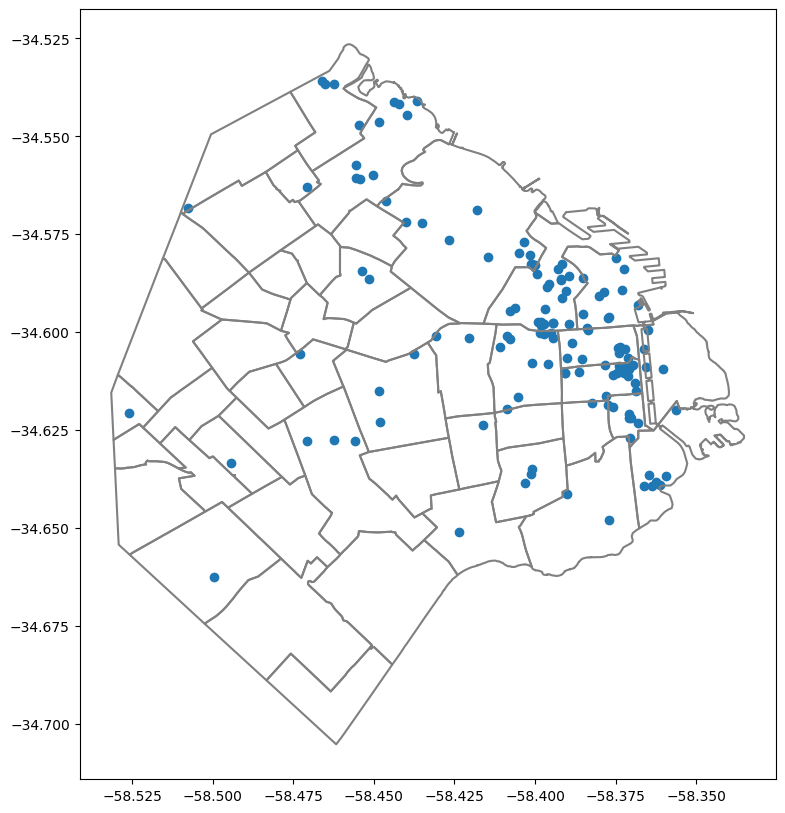

In [6]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [7]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [8]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [9]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

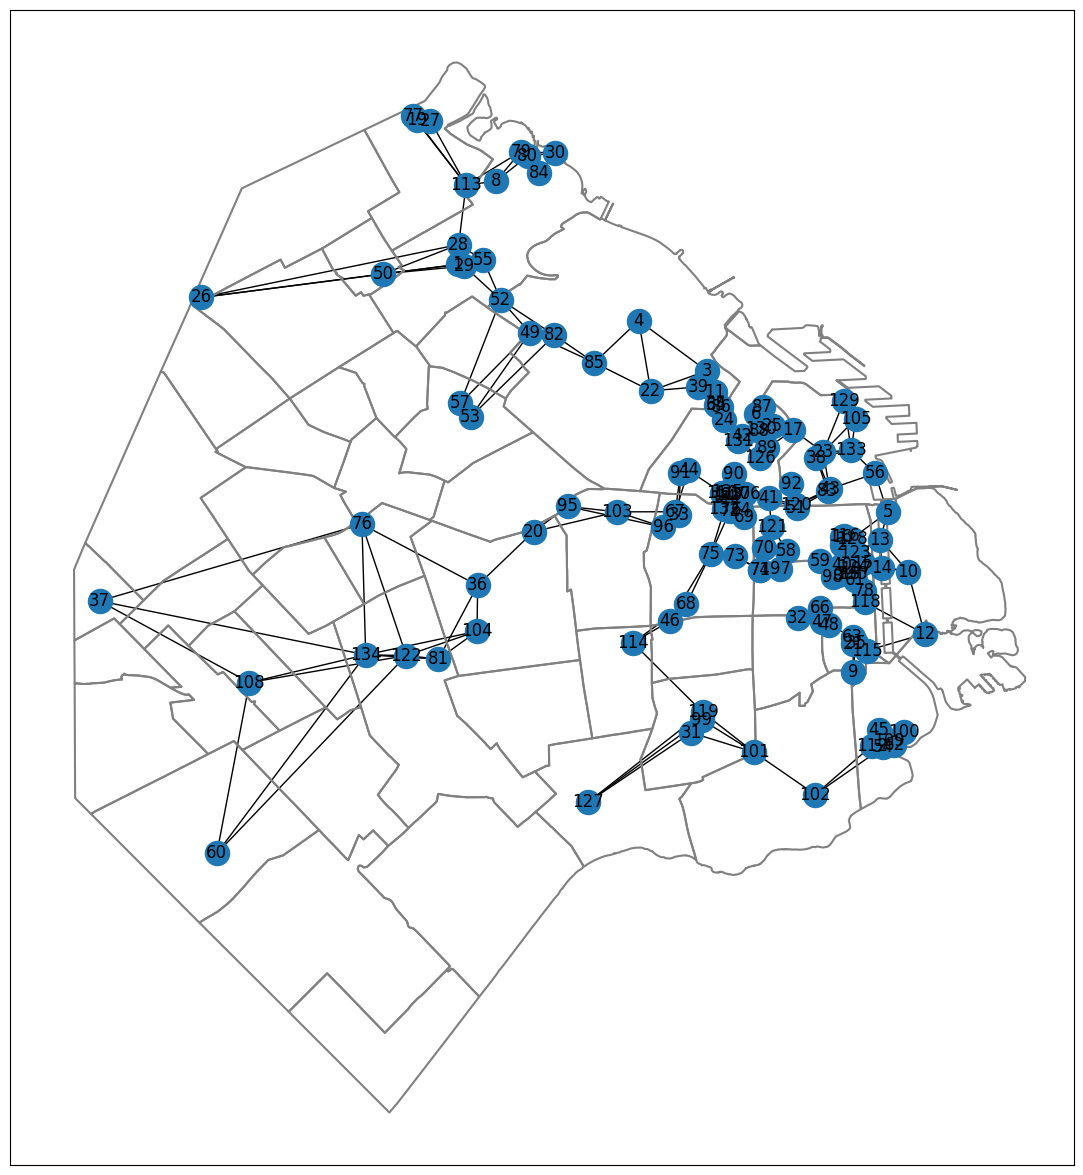

In [10]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la definicion de p
$$
p = (1-\alpha)Cp + \frac{\alpha}{N}\textbf{1} \\
p - (1-\alpha)Cp = \frac{\alpha}{N}\textbf{1} \\
(I + (1-\alpha)C)p = \frac{\alpha}{N}\textbf{1}\\
\frac{N}{\alpha}(I + (1-\alpha)C)p = \textbf{1}\\
Mp = \textbf{1} = b\\
$$
Se llega al sistema. Por lo tanto p es solucion del sistema por su definicion.

## Punto 2:


Para que la ecuación del punto anterior tenga una única solucion, la matriz M debe ser invertible. Para que M sea invertible su determinante debe ser distinto de 0. $ det(M) \neq 0 $

Usamos la  propiedad del determinante: $det(kA)=k^n$ donde $k$ es un escalar y $n$ es la dimensión de la matriz.

Por lo tanto:

$det(M) = det(\frac{N}{\alpha}(I-(1-\alpha)C))=(\frac{N}{\alpha})^N det(I-(1-\alpha)C)$

$\frac{N}{\alpha}$ es un escalar positivo, ya que $N > 0$ y $0 < \alpha < 1$, $det(M) \neq 0$ si y solo si $det(I - (1-\alpha)C)\neq 0$.



## Punto 3:

Para calcular los rankings, primero queremos hacer una función para calcular la matriz de grados $K$.

La función construir_matriz_grado toma como parametro de entrada la matriz de adyacencias $A$ que construimos a partir de leer los datos de los museos y calculando sus distancias y retorna la matriz de grados $K$ donde
$$K_{ij} = \begin{cases} 
\sum^{N}_{h=1} A_{ih}, \qquad i=j \\
0, \qquad \qquad \quad i\neq j


\end{cases}$$

Calculamos la inversa $K^{-1}$ resolviendo el sistema triangular $(K|I)$.

La función inversa_de_triangular toma como entrada una matriz triangular $M$ y resuelve el sistema $(M|I)$.

Ahora creamos la matriz de transiciones $C = A^T K^{-1}$.

La función crear_matriz_transiciones toma dos matrices $A, K^{-1}$ y retorna el producto entre la transpuesta de $A$ y $K^{-1}$.

Finalmente la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ será la matriz de puntajes.

La función toma una matriz de transiciones $C$, construye la matriz $M=\frac{N}{\alpha}(I-(1-\alpha)C)$ y retorna la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ utilizando descomposición LU.

Encapsulamos todo en una única función que calcula el puntaje para cada museo.

### 3.a

Construimos la red conectando a cada museo con sus $m = 3$ vecino más cercanos y procedemos a graficar la red asignando un tamaño proporcional a cada nodo según su Page Rank, para ello utilizamos la función calcular_puntajes definida anteriormente. 

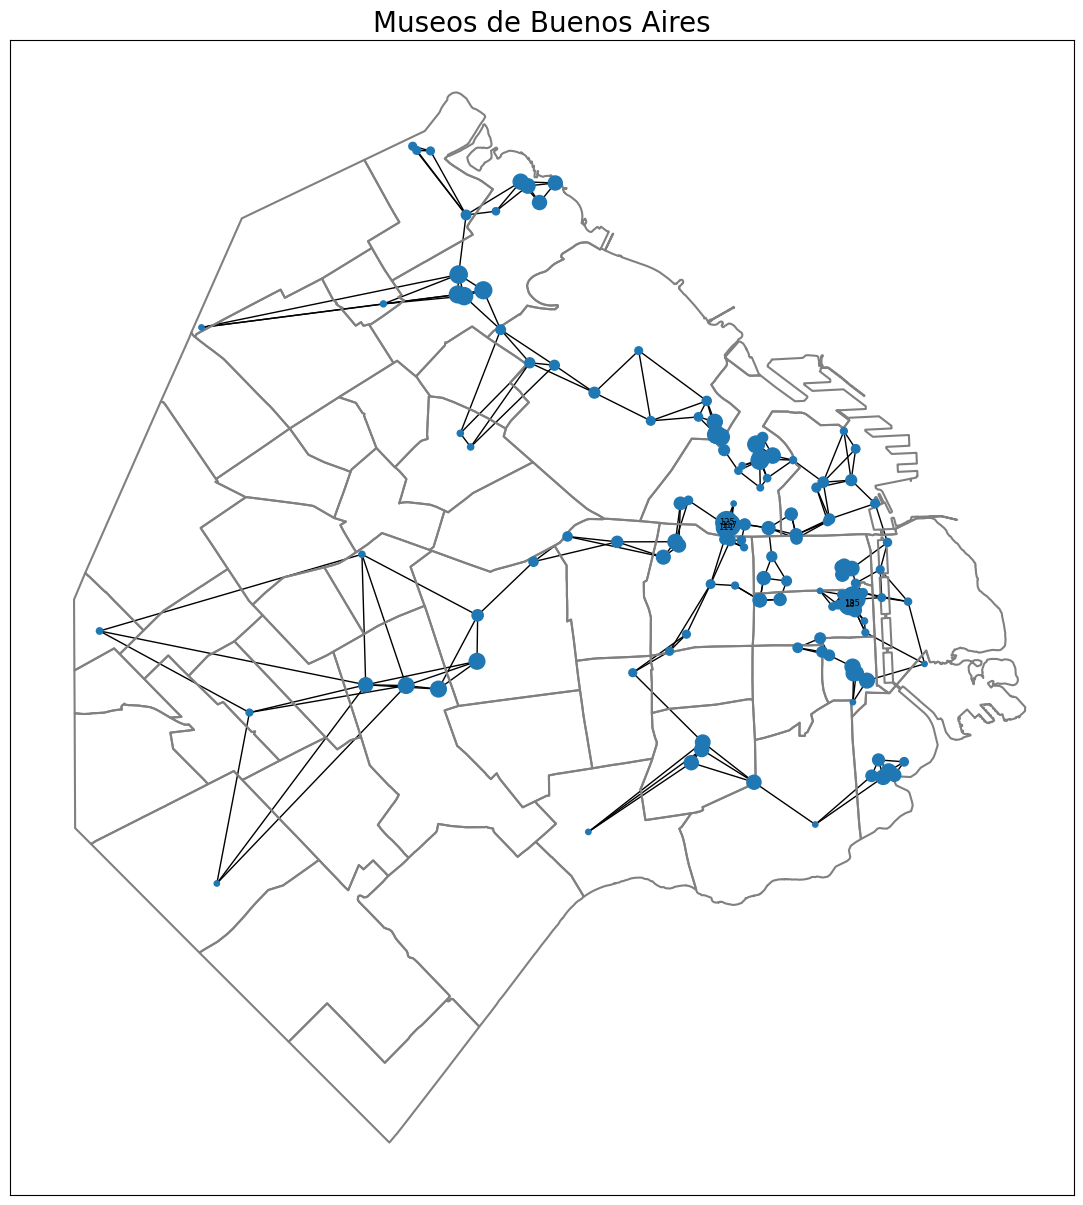

In [13]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = calcula_pagerank(A, 1/5)# Este va a ser su score Page Rank
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

#titulo
plt.title('Museos de Buenos Aires', fontsize=20)

plt.show()

### 3.b

## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres